# Data Retrieval - Climate data

## CRU Data

In [1]:
import gzip
import os
import shutil
import tempfile
import netCDF4
from netCDF4 import Dataset
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
lon = 16.363449
lat = 48.210033

In [9]:
val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
fold_n = '/Users/davidschildberger/03_LeWagon_Datasets/CRU_raw_data_2021/'

In [10]:
def get_filename(feat_name):
    fi_n = os.listdir(fold_n)
    fi_n.remove('.DS_Store')
    for i in fi_n: 
        if(feat_name in i) : 
            return i

In [11]:
def open_netcdf(fname):
    with gzip.open((fold_n+fname), 'rb') as f:
        tmp = tempfile.NamedTemporaryFile(delete=False)
        shutil.copyfileobj(f, tmp)

        f.close()
        tmp.close()
        
        data = netCDF4.Dataset(tmp.name)
        os.unlink(tmp.name)
    return data

In [12]:
def retrieve_CRU_data(datatype, year, lon, lat):
    
    data = open_netcdf(get_filename(datatype)) # 0 = 'cld'
    
    year_in_month = (year-1901)*12
    
    c_lat = int(round(np.interp(lat, [-90, 90], [0, 360])))  # check order of values here
    c_lon = int(round(np.interp(lon, [-180, 180], [0, 720])))
    
    temp_dat_date = data.variables[datatype][year_in_month:year_in_month+12,c_lat,c_lon].data
    return temp_dat_date

In [13]:
sp_dat = retrieve_CRU_data('cld', 1980, lon, lat)
sp_dat, sp_dat.mean()

(array([80.5     , 70.9     , 78.5     , 65.9     , 63.2     , 68.1     ,
        65.3     , 57.9     , 52.100002, 65.4     , 78.6     , 71.1     ],
       dtype=float32),
 68.12499)

In [439]:
def retrieve_all_features_mean_CRU_data(year, lon, lat):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    mean_val = []
    for val in val_nam_list:
        mean_val.append(retrieve_CRU_data(val, year, lon, lat).mean())
    return dict(zip(val_nam_list, mean_val))

In [440]:
retrieve_all_features_mean_CRU_data(1980, lon, lat)

{'cld': 67.53333,
 'dtr': 7.6083336,
 'frs': 9.624166,
 'pet': 1.9583334,
 'pre': 49.899998,
 'tmn': 5.066667,
 'tmp': 8.841666,
 'tmx': 12.675,
 'vap': 9.216666,
 'wet': 12.561666}

### Bio Variables / slow?!

In [295]:
## BIO1 = Annual Mean Temperature
def bio_1_annual_mean_temp(year, lon, lat):
    temp_mean = 'tmp'
    return retrieve_CRU_data(temp_mean, year, lon, lat).mean()

In [296]:
bio_1_annual_mean_temp(1980, lon, lat)

8.841666

In [298]:
## Mean Diurnal Range (Mean of monthly (max temp - min temp))
def bio_2_mean_diurnal_range(year, lon, lat):
    t_min = retrieve_CRU_data('tmn', year, lon, lat)
    t_max = retrieve_CRU_data('tmx', year, lon, lat)
    diurnal = t_max-t_min
    return diurnal.mean()

In [299]:
bio_2_mean_diurnal_range(1980, lon, lat)

7.6083336

In [402]:
## BIO3 = Isothermality (BIO2/BIO7) (×100)
def bio_3_isothermality(year, lon, lat):
    val = bio_2_mean_diurnal_range(year, lon, lat)/bio_7_temp_range(year, lon, lat)
    return val

In [403]:
bio_3_isothermality(1980, lon, lat)

0.24863835

In [311]:
## BIO4 = Temperature Seasonality (standard deviation ×100)
def bio_4_temperature_seasonality(year, lon, lat):
    t_mean = retrieve_CRU_data('tmp', year, lon, lat)
    return np.std(t_mean)

In [312]:
bio_4_temperature_seasonality(1980, lon, lat)

7.3900223

In [314]:
## BIO5 = Max Temperature of Warmest Month
def bio_5_max_temp_of_max_month(year, lon, lat):
    t_max = retrieve_CRU_data('tmx', year, lon, lat)
    return np.max(t_max)

In [316]:
bio_5_max_temp_of_max_month(1980, lon, lat)

24.9

In [328]:
## BIO6 = Min Temperature of Coldest Month
def bio_6_min_temp_of_min_month(year, lon, lat):
    t_min = retrieve_CRU_data('tmn', year, lon, lat)
    return np.min(t_min)

In [329]:
bio_6_min_temp_of_min_month(1980, lon, lat)

-5.7000003

In [330]:
## BIO7 = Temperature Annual Range (BIO5-BIO6)
def bio_7_temp_range(year, lon, lat):
    rang_temp = bio_5_max_temp_of_max_month(year, lon, lat)-bio_6_min_temp_of_min_month(year, lon, lat)
    return rang_temp

In [331]:
bio_7_temp_range(1980, lon, lat)

30.6

In [351]:
## BIO8 = Mean Temperature of Wettest Quarter
def bio_8_mean_temp_wet_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('tmp', year, lon, lat)[st:st+3].mean()

In [352]:
bio_8_mean_temp_wet_q(1980, lon, lat)

4.1666665

In [353]:
## BIO9 = Mean Temperature of Driest Quarter
def bio_9_mean_temp_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('tmp', year, lon, lat)[st:st+3].mean()

In [354]:
bio_9_mean_temp_dry_q(1980, lon, lat)

17.7

In [340]:
## BIO10 = Mean Temperature of Warmest Quarter
def bio_10_mean_temp_warm_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return temp_wet[st:st+3].mean()

In [341]:
bio_10_mean_temp_warm_q(1980, lon, lat)

17.7

In [343]:
## BIO11 = Mean Temperature of Coldest Quarter
def bio_11_mean_temp_cold_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return temp_wet[st:st+3].mean()

In [344]:
bio_11_mean_temp_cold_q(1980, lon, lat)

1.1

In [349]:
## BIO12 = Annual Precipitation
def bio_12_annual_prec(year, lon, lat):
    return retrieve_CRU_data('pre', year, lon, lat).sum()

In [350]:
bio_12_annual_prec(1980, lon, lat)

598.8

In [361]:
## BIO13 = Precipitation of Wettest Month
def bio_13_prec_wet_mo(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    max_index=np.argmax(temp_wet)
    return retrieve_CRU_data('pre', year, lon, lat)[max_index]

In [362]:
bio_13_prec_wet_mo(1980, lon, lat)

75.1

In [363]:
## BIO14 = Precipitation of Driest Month
def bio_14_prec_dry_mo(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    min_index=np.argmin(temp_wet)
    return retrieve_CRU_data('pre', year, lon, lat)[min_index]

In [364]:
bio_14_prec_dry_mo(1980, lon, lat)

34.7

In [375]:
## BIO15 = Precipitation Seasonality (Coefficient of Variation)
def bio_15_prec_wet_mo(year, lon, lat):
    temp_pre = retrieve_CRU_data('pre', year, lon, lat)
    cv = lambda x: np.std(temp_pre, ddof=1) / np.mean(temp_pre) * 100
    return cv(temp_pre)

In [376]:
bio_15_prec_wet_mo(1980, lon, lat)

46.613526344299316

In [405]:
## BIO16 = Precipitation of Wettest Quarter
def bio_16_pre_wet_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [406]:
bio_16_pre_wet_q(1980, lon, lat)

57.333332

In [385]:
## BIO17 = Precipitation of Driest Quarter
def bio_17_pre_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('wet', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [386]:
bio_17_pre_dry_q(1980, lon, lat)

47.766666

In [387]:
## BIO18  Precipitation of Warmest Quarter...
def bio_18_pre_dry_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    max_index=li_temp.index(max(li_temp))
    ll = [0,3,6,9]
    st = ll[max_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [388]:
bio_18_pre_dry_q(1980, lon, lat)

47.766666

In [419]:
## BIO19 = Precipitation of Coldest Quarter...
def bio_19_pre_cld_q(year, lon, lat):
    temp_wet = retrieve_CRU_data('tmp', year, lon, lat)
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(temp_wet[i:i+3].sum())
    min_index=li_temp.index(min(li_temp))
    ll = [0,3,6,9]
    st = ll[min_index]
    return retrieve_CRU_data('pre', year, lon, lat)[st:st+3].mean()

In [420]:
bio_19_pre_cld_q(1980, lon, lat)

28.200003

In [421]:
def get_bioclim_var(year, lon, lat):
    temp_li = []
    temp_li.append(bio_1_annual_mean_temp(year, lon, lat))
    temp_li.append(bio_2_mean_diurnal_range(year, lon, lat))
    temp_li.append(bio_3_isothermality(year, lon, lat))
    temp_li.append(bio_4_temperature_seasonality(year, lon, lat))
    temp_li.append(bio_5_max_temp_of_max_month(year, lon, lat))
    temp_li.append(bio_6_min_temp_of_min_month(year, lon, lat))
    temp_li.append(bio_7_temp_range(year, lon, lat))
    temp_li.append(bio_8_mean_temp_wet_q(year, lon, lat))
    temp_li.append(bio_9_mean_temp_dry_q(year, lon, lat))
    temp_li.append(bio_10_mean_temp_warm_q(year, lon, lat))
    temp_li.append(bio_11_mean_temp_cold_q(year, lon, lat))
    temp_li.append(bio_12_annual_prec(year, lon, lat))
    temp_li.append(bio_13_prec_wet_mo(year, lon, lat))
    temp_li.append(bio_14_prec_dry_mo(year, lon, lat))
    temp_li.append(bio_15_prec_wet_mo(year, lon, lat))
    temp_li.append(bio_16_pre_wet_q(year, lon, lat))
    temp_li.append(bio_17_pre_dry_q(year, lon, lat))
    temp_li.append(bio_18_pre_cld_q(year, lon, lat))
    temp_li.append(bio_19_pre_cld_q(year, lon, lat))
    return temp_li

In [422]:
get_bioclim_var(1980, lon, lat)

[8.841666,
 7.6083336,
 0.24863835,
 7.3900223,
 24.9,
 -5.7000003,
 30.6,
 4.1666665,
 17.7,
 17.7,
 1.1,
 598.8,
 75.1,
 34.7,
 46.613526344299316,
 57.333332,
 47.766666,
 28.200003,
 28.200003]

### Bio variables / optimized

In [ ]:
def retrieve_CRU_data_all(datatype, year):
    data = open_netcdf(get_filename(datatype))
    return data.variables[datatype][year_in_month:year_in_month+12,:,:].data

In [424]:
dat_t = retrieve_CRU_data_all('cld', 1980)
dat_t.shape

(12, 360, 720)

In [436]:
def retrieve_all_features_CRU_data(year):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    val_t = []
    for val in val_nam_list:
        val_t.append(retrieve_CRU_data_all(val, year))
    return np.array(val_t)

In [437]:
dat_ = retrieve_all_features_mean_CRU_data(1980)
dat_

array([[[[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         ...,
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36]],

        [[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
          9.96921e+36, 9.96921e+36],
         ...,
         [9.96921e+36, 9.96921e+36

In [438]:
dat_.shape

(10, 12, 360, 720)

In [448]:
def retrieve_all_features_all_years_CRU_data(year_start, year_stop):
    val_nam_list = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
    
    year_start_in_month = (year_start-1901)*12
    year_stop_in_month = (year_stop-1901)*12
    
    val_t = []
    for val in val_nam_list:
        data = open_netcdf(get_filename(val))
        val_t.append(data.variables[val][year_start_in_month:year_stop_in_month,:,:].data)
    return np.array(val_t)

In [451]:
dt = retrieve_all_features_all_years_CRU_data(1980,1982)
dt.shape

(10, 24, 360, 720)

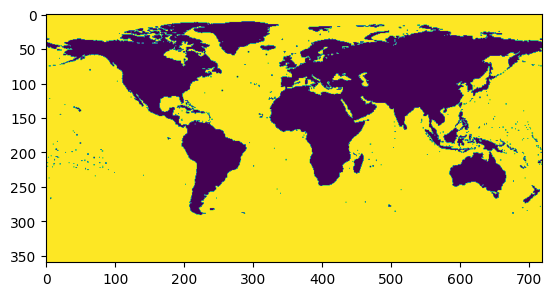

In [515]:
plt.imshow(np.flip(dt[0,0,:,:],0));

### Bio variables / individual features

In [14]:
## BIO1 = Annual Mean Temperature
def bio_1(year):
    val = 'tmp'
    data = open_netcdf(get_filename(val))
    
    year_in_month = (year-1901)*12
    
    d = data.variables[val][year_in_month:year_in_month+12,:,:].data.mean(axis=0)
    d[d > 50000] = np.nan
    res = np.flip(d,0)
    return res

In [15]:
b1 = bio_1(1980)
b1.shape

(360, 720)

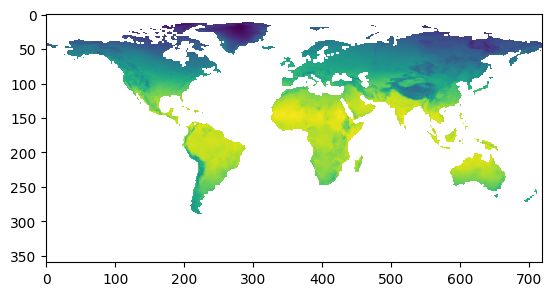

In [1269]:
plt.imshow(b1);

In [61]:
## Mean Diurnal Range (Mean of monthly (max temp - min temp))
def bio_2(year):
    data_tmn = open_netcdf(get_filename('tmn'))
    data_tmx = open_netcdf(get_filename('tmx'))
    year_in_month = (year-1901)*12
    
    t_min = data_tmn.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    t_max = data_tmx.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    t_min[t_min > 255] = np.nan
    t_max[t_max > 255] = np.nan
    d = t_max - t_min
    d = d.mean(axis=0)
    d[d > 50000] = np.nan
    res = np.flip(d,0)
    return res

In [1310]:
b2 = bio_2(1980)

In [1311]:
b2.shape

(360, 720)

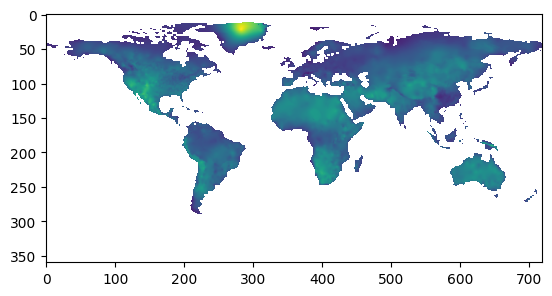

In [1312]:
plt.imshow(b2);

In [62]:
## BIO3 = Isothermality (BIO2/BIO7) (×100)
def bio_3(year):
    val = bio_2(year)/bio_7(year)
    val[val > 50000] = np.nan
    return val

In [1330]:
b3 = bio_3(1980)

In [1331]:
b3.shape

(360, 720)

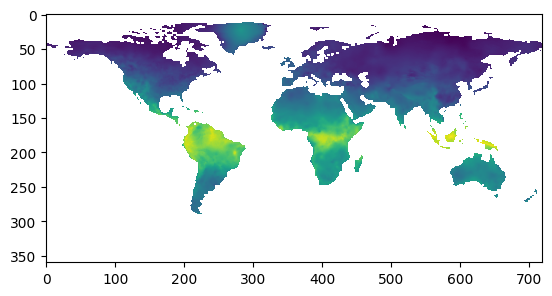

In [1332]:
plt.imshow(b3);

In [63]:
## BIO4 = Temperature Seasonality (standard deviation ×100)
def bio_4(year):
    data = open_netcdf(get_filename('tmp'))

    year_in_month = (year-1901)*12
    
    t_mp = data.variables['tmp'][year_in_month:year_in_month+12,:,:].data
    t_mp[t_mp > 50000] = np.nan
    res = np.std(t_mp, axis=0)
    res = np.flip(res,0)
    return res

In [1302]:
b4 = bio_4(1980)

In [1303]:
b4.shape

(360, 720)

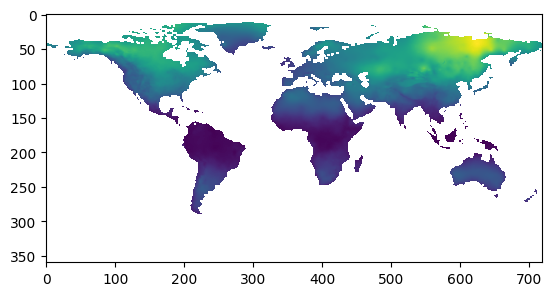

In [1304]:
plt.imshow(b4);

In [64]:
## BIO5 = Max Temperature of Warmest Month
def bio_5(year):
    data = open_netcdf(get_filename('tmx'))

    year_in_month = (year-1901)*12
    
    t_max = data.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    t_max[t_max > 50000] = np.nan
    res = np.max(t_max, axis=0)
    res = np.flip(res,0)
    return res

In [1298]:
b5 = bio_5(1980)

In [1299]:
b5.shape

(360, 720)

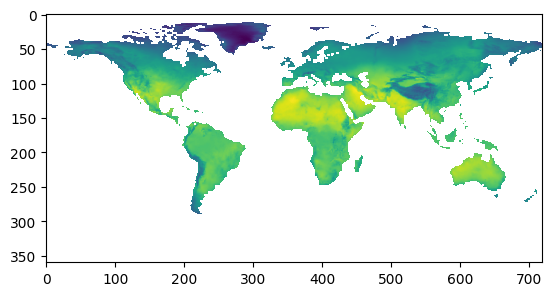

In [1300]:
plt.imshow(b5);

In [65]:
## BIO6 = Min Temperature of Coldest Month
def bio_6(year):
    data = open_netcdf(get_filename('tmn'))

    year_in_month = (year-1901)*12
    
    t_min = data.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    t_min[t_min > 50000] = np.nan
    res = np.min(t_min, axis=0)
    res = np.flip(res,0)
    return res

In [1293]:
b6 = bio_6(1980)

In [1294]:
b6.shape

(360, 720)

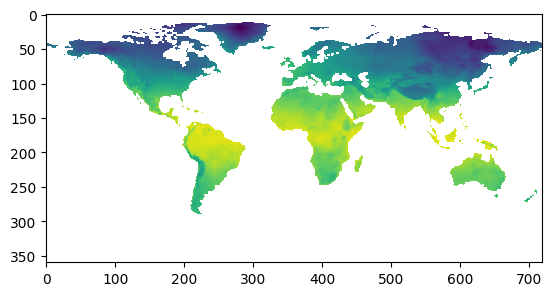

In [1296]:
plt.imshow(b6);

In [66]:
## BIO7 = Temperature Annual Range (BIO5-BIO6)
def bio_7(year):
    rang_temp = bio_5(1980)-bio_6(1980)
    rang_temp[rang_temp > 50000] = np.nan
    return rang_temp

In [1320]:
b7 = bio_7(1980)

In [1321]:
b7.shape

(360, 720)

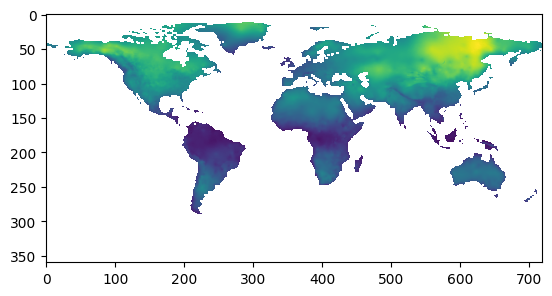

In [1322]:
plt.imshow(b7);

In [67]:
## BIO8 = Mean Temperature of Wettest Quarter
def bio_8(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1334]:
b8 = bio_8(1980)

In [1335]:
b8.shape

(360, 720)

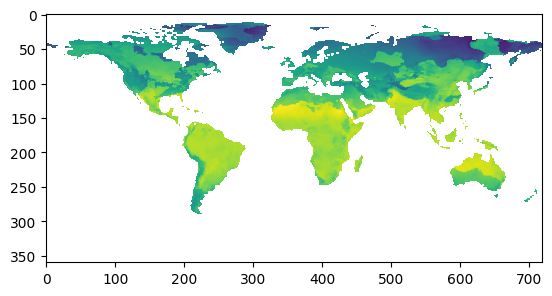

In [1336]:
plt.imshow(b8);

In [68]:
## BIO9 = Mean Temperature of Driest Quarter
def bio_9(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1338]:
b9 = bio_9(1980)

In [1339]:
b9.shape

(360, 720)

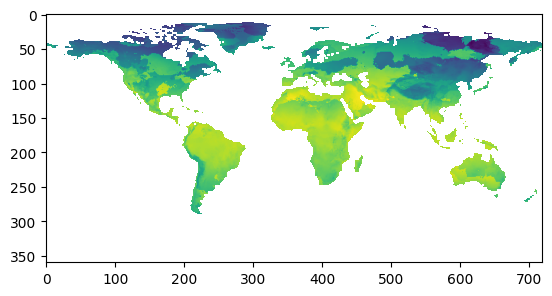

In [1340]:
plt.imshow(b9);

In [69]:
## BIO10 = Mean Temperature of Warmest Quarter
def bio_10(year):
    data_wet = open_netcdf(get_filename('tmx'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmx'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1342]:
b10 = bio_10(1980)

In [1343]:
b10.shape

(360, 720)

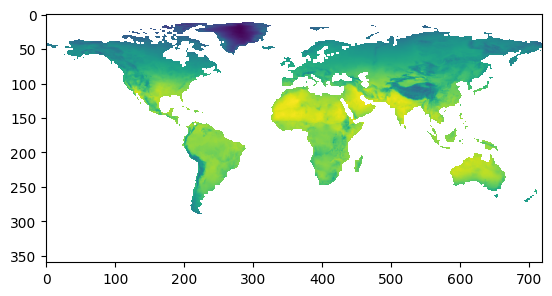

In [1344]:
plt.imshow(b10);

In [70]:
## BIO11 = Mean Temperature of Coldest Quarter
def bio_11(year):
    data_wet = open_netcdf(get_filename('tmn'))
    data_tmp = open_netcdf(get_filename('tmp'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.mean(data_tmp.variables['tmp'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1350]:
b11 = bio_11(1980)

In [1351]:
b11.shape

(360, 720)

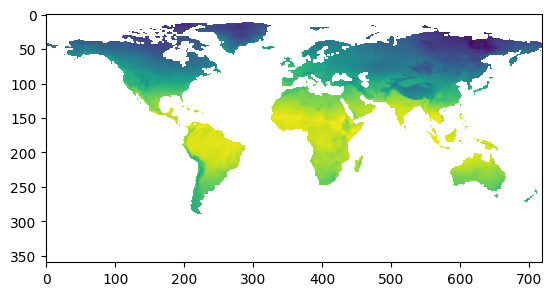

In [1352]:
plt.imshow(b11);

In [71]:
## BIO12 = Annual Precipitation
def bio_12(year):
    data_pre = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_pre.variables['pre'][year_in_month:year_in_month+12,:,:].data
    temp_wet[temp_wet > 50000000] = np.nan
    temp_wet = np.sum(temp_wet, axis=0)
    res = np.flip(temp_wet,0)
    return res

In [1354]:
b12 = bio_12(1980)

In [1355]:
b12.shape

(360, 720)

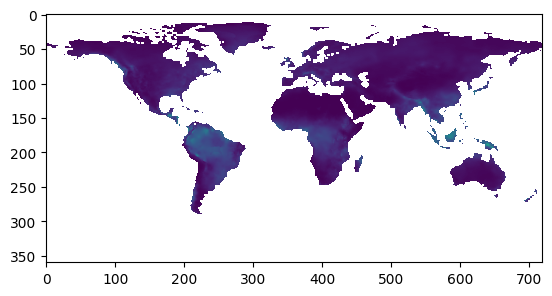

In [1356]:
plt.imshow(b12);

In [72]:
## BIO13 = Precipitation of Wettest Month
def bio_13(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    max_ind = np.argmax(temp_wet, axis=0)
        
    res = np.choose(max_ind, data_tmp.variables['pre'][year_in_month:year_in_month+12,:,:].data)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1358]:
b13 = bio_13(1980)

In [1359]:
b13.shape

(360, 720)

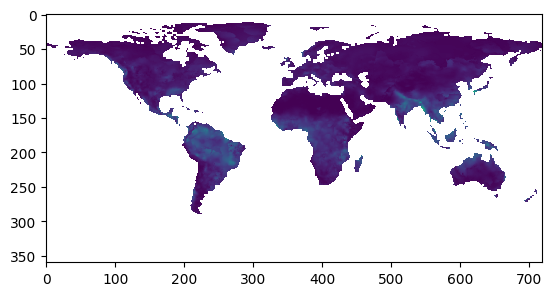

In [1360]:
plt.imshow(b13);

In [73]:
## BIO14 = Precipitation of Driest Month
def bio_14(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    min_ind = np.argmin(temp_wet, axis=0)
        
    res = np.choose(min_ind, data_tmp.variables['pre'][year_in_month:year_in_month+12,:,:].data)
    res[res > 50000] = np.nan
    res = np.flip(res,0)
    return res

In [1362]:
b14 = bio_14(1980)

In [1363]:
b14.shape

(360, 720)

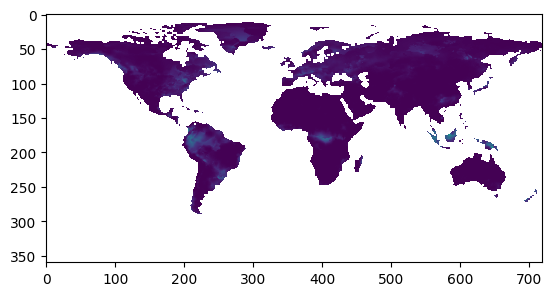

In [1364]:
plt.imshow(b14);

In [74]:
## BIO15 = Precipitation Seasonality (Coefficient of Variation)
def bio_15(year):
    val = 'pre'
    data = open_netcdf(get_filename(val))
    
    year_in_month = (year-1901)*12
    
    d = data.variables[val][year_in_month:year_in_month+12,:,:].data
    d[d > 500000] = np.nan
    cv = lambda x: np.std(d, ddof=1, axis=0) / np.mean(d, axis=0) * 100
    d = cv(d)
    res = np.flip(d,0)
    return res

In [1366]:
b15 = bio_15(1980)

/var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/ipykernel_34377/2129893429.py:10: RuntimeWarning: invalid value encountered in divide
  cv = lambda x: np.std(d, ddof=1, axis=0) / np.mean(d, axis=0) * 100


In [1367]:
b15.shape

(360, 720)

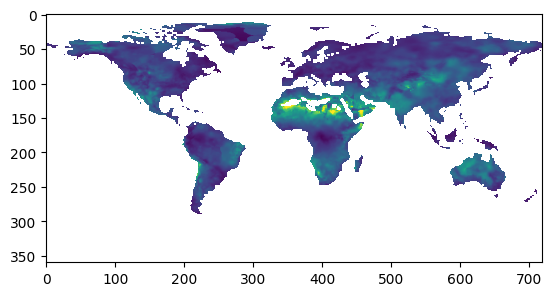

In [1368]:
plt.imshow(b15);

In [75]:
## BIO16 = Precipitation of Wettest Quarter
def bio_16(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    return res

In [1370]:
b16 = bio_16(1980)

In [1371]:
b16.shape

(360, 720)

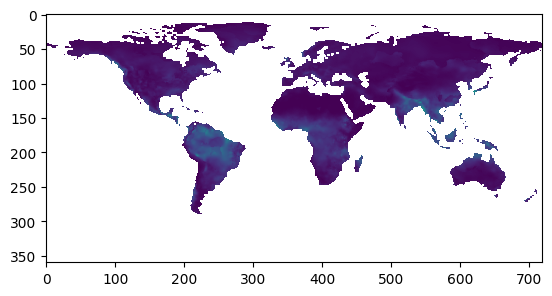

In [1372]:
plt.imshow(b16);

In [76]:
## BIO17 = Precipitation of Driest Quarter
def bio_17(year):
    data_wet = open_netcdf(get_filename('wet'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['wet'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    return res

In [1374]:
b17 = bio_17(1980)

In [1375]:
b17.shape

(360, 720)

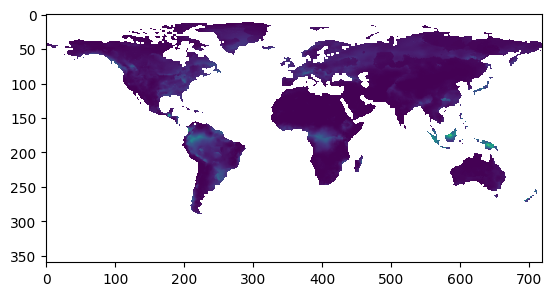

In [1376]:
plt.imshow(b17);

In [77]:
## BIO18  Precipitation of Warmest Quarter...
def bio_18(year):
    data_wet = open_netcdf(get_filename('tmp'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmp'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    max_ind = np.argmax(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(max_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    return res

In [1378]:
b18 = bio_18(1980)

In [1379]:
b18.shape

(360, 720)

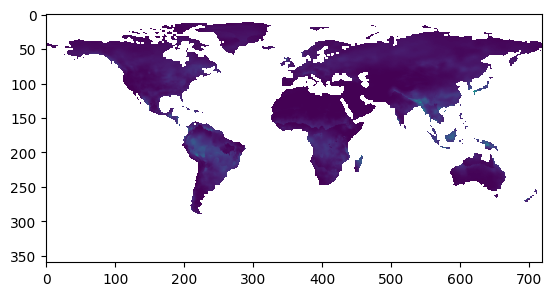

In [1380]:
plt.imshow(b18);

In [78]:
## BIO19 = Precipitation of Coldest Quarter...
def bio_19(year):
    data_wet = open_netcdf(get_filename('tmn'))
    data_tmp = open_netcdf(get_filename('pre'))
    
    year_in_month = (year-1901)*12
    
    temp_wet =  data_wet.variables['tmn'][year_in_month:year_in_month+12,:,:].data
    
    li_temp = []
    for i in range(0,11,3):
        li_temp.append(np.sum(temp_wet[i:i+3], axis=0))
    li_temp = np.array(li_temp)
    min_ind = np.argmin(li_temp, axis=0)
    
    li_q_t = []
    for i in range(0,11,3):
        li_q_t.append(np.sum(data_tmp.variables['pre'][year_in_month+i:year_in_month+i+3,:,:].data, axis=0))

    li_q_t = np.array(li_q_t)
    
    res = np.choose(min_ind, li_q_t)
    res[res > 500000] = np.nan
    res = np.flip(res,0)
    return res

In [1382]:
b19 = bio_19(1980)

In [1383]:
b19.shape

(360, 720)

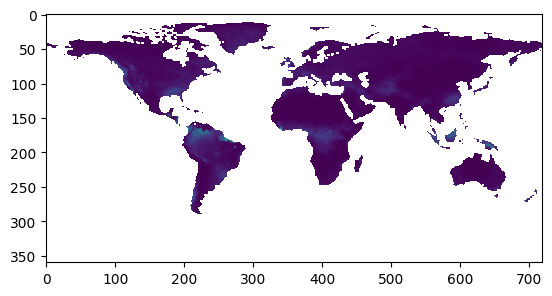

In [1384]:
plt.imshow(b19);

### Create and save bioclim files for each year

In [90]:
def create_and_save_bioclim():
    for i in range(11,20):
        st = 1901+i
        os.makedirs(f"../raw_data/bioclim/{st}")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_1.csv", 
                   bio_1(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_2.csv", 
                   bio_2(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_3.csv", 
                   bio_3(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_4.csv", 
                   bio_4(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_5.csv", 
                   bio_5(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_6.csv", 
                   bio_6(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_7.csv", 
                   bio_7(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_8.csv", 
                   bio_8(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_9.csv", 
                   bio_9(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_10.csv", 
                   bio_10(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_11.csv", 
                   bio_11(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_12.csv", 
                   bio_12(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_13.csv", 
                   bio_13(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_14.csv", 
                   bio_14(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_15.csv", 
                   bio_15(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_16.csv", 
                   bio_16(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_17.csv", 
                   bio_17(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_18.csv", 
                   bio_18(st), delimiter=",")
        np.savetxt(f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{st}/bio_19.csv", 
                   bio_19(st), delimiter=",")

In [ ]:
create_and_save_bioclim()

/var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/ipykernel_53909/2129893429.py:10: RuntimeWarning: invalid value encountered in divide
  cv = lambda x: np.std(d, ddof=1, axis=0) / np.mean(d, axis=0) * 100


### Retrieve Bioclim Data for plants

In [1518]:
def get_plant_features():
    df = pd.read_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/subset_329207sp_cleaned.csv", on_bad_lines='skip')
    df = df[['gbifID', 'kingdom', 'species', 'scientificName', 'decimalLatitude', 'decimalLongitude','countryCode', 'year']]
    return df

In [1526]:
df_init = get_bio_features_plans()

/var/folders/jj/6lhmrlt15xs297nzzcs7734w0000gn/T/ipykernel_34377/1026233943.py:2: DtypeWarning: Columns (12,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/subset_329207sp_cleaned.csv", on_bad_lines='skip')


In [1528]:
def get_bioclim_from_plants(df):
    df[['b1', 'b2', 'b3', 'b4', 'b5','b6','b7','b8','b9','b10','b11','b12','b13','b14',
            'b15','b16','b17','b18','b19']] = np.nan
    for i in range(len(df)):
        lat = df.loc[i, 'decimalLatitude']
        lon = df.loc[i, 'decimalLongitude']
        c_lat = int(round(np.interp(lat, [-89, 89], [359, 0])))  # check order of values here
        c_lon = int(round(np.interp(lon, [-179, 179], [1, 719])))
        df.loc[i, 'b1'] = b1[c_lat, c_lon]
        df.loc[i, 'b2'] = b2[c_lat, c_lon]
        df.loc[i, 'b3'] = b3[c_lat, c_lon]
        df.loc[i, 'b4'] = b4[c_lat, c_lon]
        df.loc[i, 'b5'] = b5[c_lat, c_lon]
        df.loc[i, 'b6'] = b6[c_lat, c_lon]
        df.loc[i, 'b7'] = b7[c_lat, c_lon]
        df.loc[i, 'b8'] = b8[c_lat, c_lon]
        df.loc[i, 'b9'] = b9[c_lat, c_lon]
        df.loc[i, 'b10'] = b10[c_lat, c_lon]
        df.loc[i, 'b11'] = b11[c_lat, c_lon]
        df.loc[i, 'b12'] = b12[c_lat, c_lon]
        df.loc[i, 'b13'] = b13[c_lat, c_lon]
        df.loc[i, 'b14'] = b14[c_lat, c_lon]
        df.loc[i, 'b15'] = b15[c_lat, c_lon]
        df.loc[i, 'b16'] = b16[c_lat, c_lon]
        df.loc[i, 'b17'] = b17[c_lat, c_lon]
        df.loc[i, 'b18'] = b18[c_lat, c_lon]
        df.loc[i, 'b19'] = b19[c_lat, c_lon]
    df.dropna(inplace=True)
    df.to_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/plant_data_inkl_bioclim.csv")
    return df

In [1529]:
df = get_bioclim_from_plants(df_init)
df.head()

,gbifID,kingdom,species,scientificName,decimalLatitude,decimalLongitude,countryCode,year,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19
0,1320983475,Animalia,Plethodon ventralis,"Plethodon ventralis Highton, 1997",35.6389,-83.7478,US,1962.0,13.608333,13.208333,0.342185,8.586759,32.900002,-5.7,38.600002,4.066667,8.033334,24.500000,4.066667,1139.599976,213.000000,55.400002,47.724819,384.899994,175.900009,297.000000,384.899994
2,1322501794,Animalia,Cypho zaps,"Cypho zaps Gill, 2004",16.3300,119.8700,PH,1995.0,27.750000,9.099999,0.631944,1.196175,34.900002,20.5,14.400002,27.733332,26.600000,29.333334,26.600000,1908.099976,367.500000,1.400000,91.464821,1014.800049,43.099998,489.600006,43.099998
4,1318143764,Animalia,Leptodactylus didymus,"Leptodactylus didymus Heyer, García-Lopez & Ca...",-12.8300,-69.2800,PE,1990.0,24.866669,11.108333,0.726035,1.094938,32.299999,17.0,15.299999,25.733335,23.766668,25.833334,23.766668,2508.900146,378.200012,31.500000,75.043335,1274.100098,215.699997,744.799988,215.699997
6,1319377461,Plantae,Desmodium longiarticulatum,Meibomia longiarticulata Rusby,-15.7896,-66.9742,BO,1921.0,22.375000,11.941667,0.663426,1.546569,30.700001,12.7,18.000000,23.466667,21.200001,23.900000,21.200001,1402.900024,211.900009,22.700001,60.877670,620.000000,148.199997,365.599976,148.199997
7,1320211719,Animalia,Xenurobrycon coracoralinae,"Xenurobrycon coracoralinae Moreira, 2005",-15.9333,-50.1500,BR,1996.0,24.708336,12.241668,0.687734,1.046787,33.400002,15.6,17.800001,24.700003,24.866667,24.866667,23.866667,1789.800049,450.000000,0.000000,122.366867,1077.400024,58.200001,550.799988,103.400009


In [1531]:
df.shape

(185255, 27)

In [ ]:
def get_bioclim_from_plants_with_year(df):
    df[['b1', 'b2', 'b3', 'b4', 'b5','b6','b7','b8','b9','b10','b11','b12','b13','b14',
            'b15','b16','b17','b18','b19']] = np.nan
     for i in range(len(df)):
        lat = df.loc[i, 'decimalLatitude']
        lon = df.loc[i, 'decimalLongitude']
        year = int(df.loc[i, 'year'])
        c_lat = int(round(np.interp(lat, [-89, 89], [359, 0])))  # check order of values here
        c_lon = int(round(np.interp(lon, [-179, 179], [1, 719])))
        
        path = f"/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/bioclim/{year}/"
        
        filen = 'bio_1.csv'
        bio_1 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b1'] = bio_1[c_lat, c_lon]
        
        filen = 'bio_2.csv'
        bio_2 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b2'] = bio_2[c_lat, c_lon]
        
        filen = 'bio_3.csv'
        bio_3 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b3'] = bio_3[c_lat, c_lon]
        
        filen = 'bio_4.csv'
        bio_4 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b4'] = bio_4[c_lat, c_lon]
        
        filen = 'bio_5.csv'
        bio_5 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b5'] = bio_5[c_lat, c_lon]
        
        filen = 'bio_6.csv'
        bio_6 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b6'] = bio_6[c_lat, c_lon]
        
        filen = 'bio_7.csv'
        bio_7 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b7'] = bio_7[c_lat, c_lon]
        
        filen = 'bio_8.csv'
        bio_8 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b8'] = bio_8[c_lat, c_lon]
        
        filen = 'bio_9.csv'
        bio_9 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b9'] = bio_9[c_lat, c_lon]
        
        filen = 'bio_10.csv'
        bio_10 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b10'] = bio_100[c_lat, c_lon]
        
        filen = 'bio_11.csv'
        bio_11 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b11'] = bio_11[c_lat, c_lon]
        
        filen = 'bio_12.csv'
        bio_12 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b12'] = bio_12[c_lat, c_lon]
        
        filen = 'bio_13.csv'
        bio_13 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b13'] = bio_13[c_lat, c_lon]
        
        filen = 'bio_14.csv'
        bio_14 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b14'] = bio_14[c_lat, c_lon]
        
        filen = 'bio_15.csv'
        bio_15 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b15'] = bio_15[c_lat, c_lon]
        
        filen = 'bio_16.csv'
        bio_16 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b16'] = bio_16[c_lat, c_lon]
        
        filen = 'bio_17.csv'
        bio_17 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b17'] = bio_17[c_lat, c_lon]
        
        filen = 'bio_18.csv'
        bio_18 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b18'] = bio_18[c_lat, c_lon]
        
        filen = 'bio_19.csv'
        bio_19 = np.genfromtxt(path+filen, delimiter=',')
        df.loc[i, 'b19'] = bio_19[c_lat, c_lon]
        
    df.dropna(inplace=True)
    df.to_csv("/Users/davidschildberger/code/dadavie/planetary_garden/raw_data/plant_data_inkl_bioclim.csv")
    return df